In [280]:
from pandasql import sqldf
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [48]:
pysqldf = lambda q: sqldf(q, globals())

In [363]:
users_df = pd.read_csv('clean_data/users_dataset.csv', index_col = 0)
brands_df = pd.read_csv('clean_data/brands_dataset.csv', index_col = 0)
receipt_df = pd.read_csv('clean_data/receipts_dataset.csv', index_col = 0)
receiptItem_df = pd.read_pickle('clean_data/receiptitems_dataset.zip')
users_df['createdDate'] = pd.to_datetime(users_df['createdDate'])
date_col = ['createDate','dateScanned','finishedDate','purchaseDate','purchaseDate']
for col in date_col:
    receipt_df[f'{col}'] = pd.to_datetime(receipt_df[f'{col}'])

In [24]:
brands_df.head(1)

,brand_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Starbucks,0.0,STARBUCKS


In [337]:
receiptItem_df.columns

Index(['receipt_id', 'barcode', 'description', 'finalPrice', 'itemPrice',
       'needsFetchReview', 'partnerItemId', 'preventTargetGapPoints',
       'quantityPurchased', 'userFlaggedNewItem', 'userFlaggedPrice',
       'userFlaggedQuantity', 'needsFetchReviewReason',
       'pointsNotAwardedReason', 'pointsPayerId', 'rewardsGroup',
       'rewardsProductPartnerId', 'originalMetaBriteBarcode',
       'originalMetaBriteDescription', 'brandCode', 'competitorRewardsGroup',
       'discountedItemPrice', 'originalReceiptItemText'],
      dtype='object')

In [328]:
receiptItem_df['finalPrice'].sum()

3126287.1600000006

In [ ]:
question1:What are the top 5 brands by receipts scanned for most recent month
    
question 2: How does the ranking of the top 5 brands by receipts scanned for 
            the recent month compare to the ranking for the previous month?
        
question 3: When considering average spend from receipts with 
            'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
        
question 4: When considering total number of items purchased 
            from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
        
question 5: Which brand has the most spend among users who were created within the past 6 months?
    
question 6: Which brand has the most transactions among users who were created within the past 6 months?


## Question 1: What are the top 5 brands by receipts scanned for most recent month?

In [321]:
q1 = """SELECT receipt_df.receipt_id, count(receiptItem_df.receipt_id) as receipt_count,

        receiptItem_df.brandCode, receipt_df.dateScanned as ds
        
        FROM receiptItem_df INNER JOIN receipt_df
        
        ON receiptItem_df.receipt_id = receipt_df.receipt_id WHERE brandCode <> "NO BRAND CODE"
        
        GROUP BY brandCode ORDER BY receipt_count DESC;"""


recent_month_top_5_brands = pysqldf(q1)
recent_month_top_5_brands = recent_month_top_5_brands.sort_values(by="ds", ascending = False)
recent_month_top_5_brands = recent_month_top_5_brands.sort_values(by="receipt_count", ascending = False)

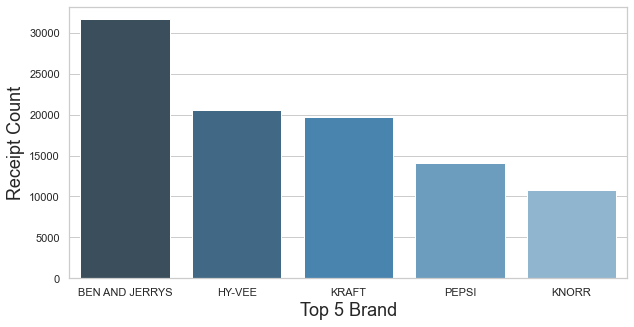

In [324]:
fig, scatter = plt.subplots(figsize = (10,5))
bar = sns.barplot(x="brandCode", y="receipt_count", data=recent_month_top_5_brands.head(5),palette="Blues_d", )
bar.set_xlabel('Top 5 Brand', fontsize = 18)
bar.set_ylabel ('Receipt Count', fontsize = 18);

 ## Question 3: When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [345]:
q3 = """SELECT receipt_df.rewardsReceiptStatus as reward_status, 
        
        avg(receipt_df.totalSpent) as avg_spend

        FROM receiptItem_df INNER JOIN receipt_df
        
        ON receiptItem_df.receipt_id = receipt_df.receipt_id GROUP BY reward_status;"""


accepted_rejected_spend = pysqldf(q3)
accepted_rejected_spend = accepted_rejected_spend['reward_status'].replace('FINISHED', 'ACCEPTED')

,reward_status,avg_spend
0,FINISHED,2416.713368
1,FLAGGED,3854.791179
2,REJECTED,31.432842


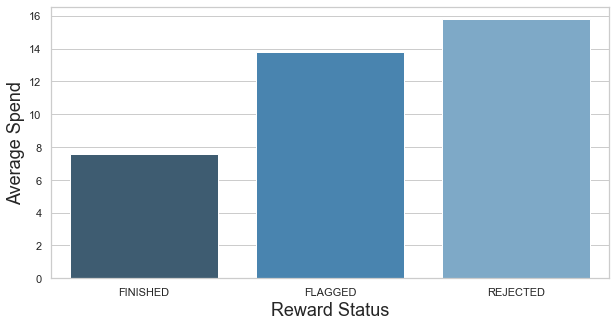

In [342]:
fig, scatter = plt.subplots(figsize = (10,5))
bar = sns.barplot(x="reward_status", y="avg_spend", data=accepted_rejected_spend ,palette="Blues_d", )
bar.set_xlabel('Reward Status', fontsize = 18)
bar.set_ylabel ('Average Spend', fontsize = 18);

## Question 4: When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [480]:
q4 = """SELECT receipt_df.rewardsReceiptStatus as reward_status, 
        
        count(receipt_df.purchasedItemCount) as items_purchased

        FROM receiptItem_df INNER JOIN receipt_df
        
        ON receiptItem_df.receipt_id = receipt_df.receipt_id GROUP BY reward_status;"""


accepted_rejected_items = pysqldf(q4)
accepted_rejected_items

,reward_status,items_purchased
0,FINISHED,330017
1,FLAGGED,45015
2,REJECTED,183


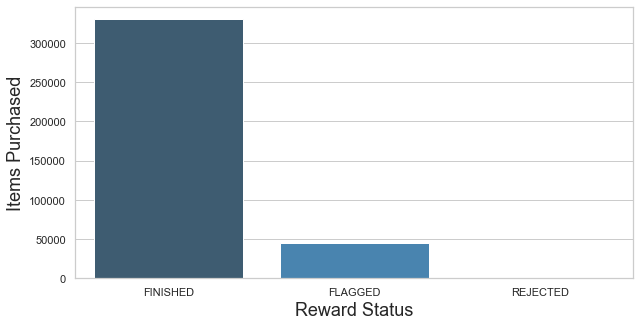

In [481]:
fig, bar = plt.subplots(figsize = (10,5))
bar = sns.barplot(x="reward_status", y="items_purchased", data=accepted_rejected_items ,palette="Blues_d", )
bar.set_xlabel('Reward Status', fontsize = 18)
bar.set_ylabel ('Items Purchased', fontsize = 18);

## Question 5: Which brand has the most spend among users who were created within the past 6 months?

In [404]:
users_df.head(1)

,user_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03,2021-01-03,consumer,Email,WI


In [415]:
from datetime import datetime
start_date = datetime(2021, 2, 2)
end_date = datetime(2020, 7, 2)

q5 = """
        SELECT receipt_df.receipt_id, users_df.user_id , users_df.createdDate, receipt_df.totalSpent
        FROM receipt_df INNER JOIN users_df
        ON users_df.user_id = receipt_df.userId;
        """

users_spent_df = pysqldf(q5)

q5v2 = """
        SELECT users_spent_df.receipt_id, users_spent_df.createdDate, users_spent_df.totalSpent, 
        receiptItem_df.brandCode
        FROM users_spent_df INNER JOIN receiptItem_df
        ON users_spent_df.receipt_id = receiptItem_df.receipt_id WHERE brandCode <> "NO BRAND CODE"
            
            """

users_spent_dfv2 = pysqldf(q5v2)
users_spent_dfv2['createdDate'] = pd.to_datetime(users_spent_dfv2['createdDate'])
users_spent_dfv2 = users_spent_dfv2.sort_values(by='createdDate',ascending=False).set_index('createdDate')

In [458]:
user_x_spent = users_spent_dfv2[(users_spent_dfv2.index <= start_date)
                 & (users_spent_dfv2.index >= end_date)]

In [475]:
user_x_spent = pd.DataFrame(user_x_spent.groupby(by='brandCode')['totalSpent'].sum().head(5))

In [476]:
user_x_spent

,totalSpent
brandCode,
7UP,3789390.30
ADVIL,1235173.11
AMERICAN BEAUTY,6374632.50
ARNOLD,144295.26
ARROWHEAD,3789390.30


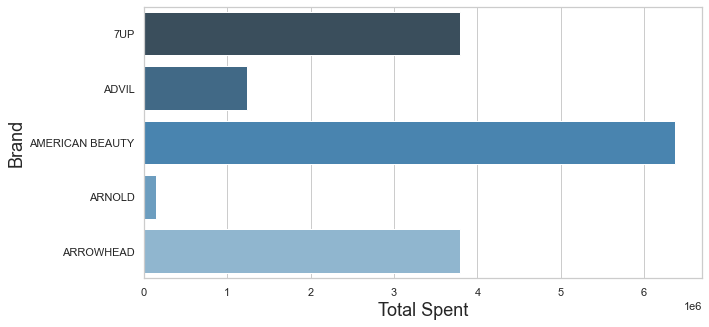

In [479]:
fig, bar = plt.subplots(figsize = (10,5))
bar = sns.barplot(x="totalSpent", y=user_x_spent.index, data= user_x_spent ,palette="Blues_d", )
bar.set_xlabel('Total Spent', fontsize = 18)
bar.set_ylabel ('Brand', fontsize = 18);